In [18]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrowPatch
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from highlight_text import fig_text, ax_text

# parameters
interpolate = True
interpolate_factor = 10

# pre processing
df = pd.read_csv('global-plastics-production.csv')
df.columns = ['Entity', 'Code', 'Year', 'plastic-production']
df = df.set_index('Year')
df.sort_values(by='Year', inplace=True)
df.drop(['Entity', 'Code'], axis=1, inplace=True)

# add value for missing year 1974
df.loc[1974] = (df.loc[1973].values + df.loc[1975].values) / 2

# predict value with fitting for 2020 up to 2050
X = df.index.values.reshape(-1, 1)
y = df['plastic-production'].values
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(X, y)
X_pred = np.arange(2020, 2051).reshape(-1, 1)
y_pred = model.predict(X_pred)
df_pred = pd.DataFrame(y_pred, index=X_pred.flatten(), columns=['plastic-production'])
df = pd.concat([df, df_pred])

# interpolation
if interpolate:
   multiple = interpolate_factor
   new_index = np.linspace(df.index.min(), df.index.max(), len(df) * multiple-(multiple-1))
   df = df.reindex(new_index).interpolate(method='polynomial', order=2)
   df.reset_index(inplace=True)
   df['Year'] = df['index'].astype(int)
   df.index = df['Year']
   df.drop(columns=['index', 'Year'], inplace=True)
   df.index = new_index

round(df.head(5))

,plastic-production
1950.0,2000000.0
1950.1,2010854.0
1950.2,2019297.0
1950.3,2025327.0
1950.4,2028945.0


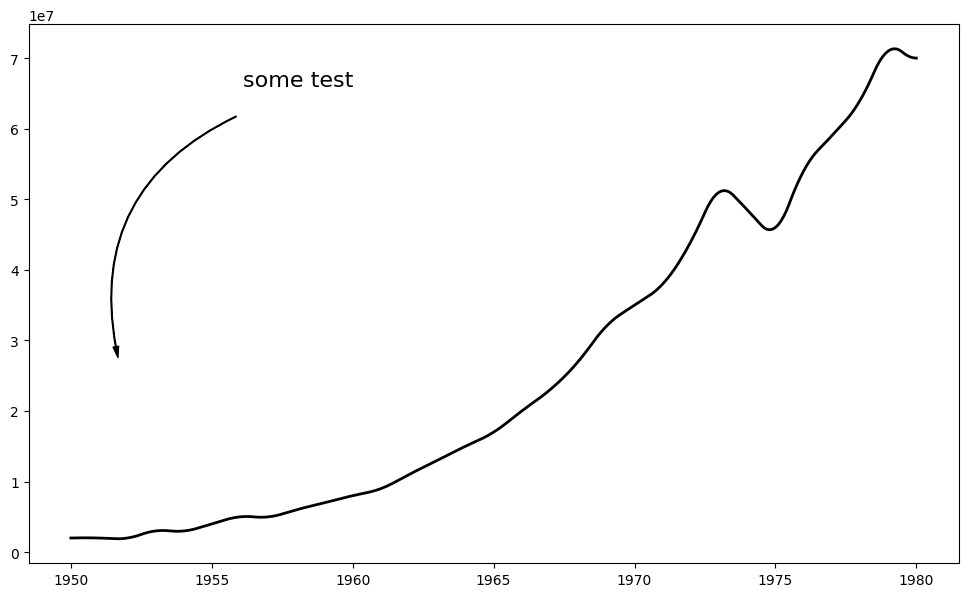

In [43]:
test = df[df.index <=1980]
fig,ax = plt.subplots(figsize=(12, 7), dpi=100)
ax.plot(test.index, test['plastic-production'], color='black', linewidth=2)
fig_text(
   x=0.35, y=0.8,
   s='some test',
   fontsize=16,
   color='black',
   ha='center',
   va='center',
   fig=fig
)
draw_arrow((0.3, 0.75), (0.2, 0.4), invert=False)


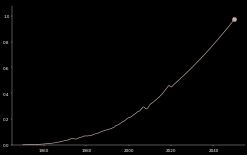

In [46]:
def draw_arrow(tail_position, head_position, invert=False):
    kw = dict(arrowstyle="Simple, tail_width=0.5, head_width=4, head_length=8", color="k")
    if invert:
        connectionstyle = "arc3,rad=-.4"
    else:
        connectionstyle = "arc3,rad=.4"
    a = FancyArrowPatch(
        tail_position, head_position,
        connectionstyle=connectionstyle,
        transform=fig.transFigure,
        **kw
    )
    fig.patches.append(a)

# parameters
background_color = 'black'
text_color = 'white'
line_color = '#c9ada7'

# Setting up the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=30)
fig.set_facecolor(background_color)
ax.set_facecolor(background_color)
ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)
ax.spines[['left', 'bottom']].set_color(text_color)

# Update function for the animation
def update(frame):

    # skip first frame
    if frame == 0:
        return None

    # initialize subset of data
    subset_df = df.iloc[:frame]
    ax.clear()

    # annotations with arrows
    if frame >= 1980:
        text = "<Evolution of actual global plastics production>"
        fig_text(
            x=0.35, y=0.8,
            s=text,
            fontsize=16,
            color=text_color,
            highlight_textprops=[{"color": 'white'}],
            ha='center',
            va='center',
            fig=fig
        )
        draw_arrow((0.3, 0.75), (0.2, 0.4), invert=False)

    # create the line chart
    ax.plot(subset_df.index, subset_df['plastic-production'], color=line_color)
    ax.scatter(subset_df.index[-1], subset_df['plastic-production'].values[-1], color=line_color, s=100)

    # custom axes
    y_min = df.iloc[:frame+1].sum(axis=1).min()
    y_max = df.iloc[:frame+1].sum(axis=1).max()
    ax.set_ylim(0, y_max*1.1)
    ax.spines[['top', 'right']].set_visible(False)

# create and save animation
ani = FuncAnimation(fig, update, frames=len(df))
ani.save('global-plastics-production.gif', writer='imagemagick', fps=15)